## First steps with Tensorflow

In [99]:
import math

import pandas as pd
import numpy as np

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow.python.data import Dataset

In [100]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

### retrieve housing data

In [101]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

In [102]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


In [136]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe['median_house_value'] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
10988,-120.9,38.3,13.0,2084.0,449.0,834.0,305.0,3.3,114.2
15480,-122.3,40.6,15.0,2524.0,449.0,1374.0,467.0,3.4,93.8
9653,-119.5,37.3,14.0,362.0,78.0,88.0,39.0,3.6,214.3
699,-117.0,33.0,17.0,9911.0,1436.0,4763.0,1414.0,5.6,194.3
1935,-117.3,33.0,30.0,2750.0,555.0,1281.0,520.0,4.7,286.9
...,...,...,...,...,...,...,...,...,...
11571,-121.3,38.8,7.0,9003.0,1739.0,4445.0,1591.0,3.8,147.9
153,-116.2,33.7,28.0,2488.0,714.0,2891.0,676.0,2.3,68.9
3967,-118.0,33.8,33.0,2362.0,394.0,1185.0,387.0,4.4,188.4
11753,-121.3,37.9,38.0,226.0,44.0,125.0,38.0,2.9,125.0


In [137]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


## Construct model


### Define features & build feature columns

In [138]:
# define the input features
my_features = california_housing_dataframe[["total_rooms"]]

# configure numeric feature column for total rooms
feature_columns = [tf.feature_column.numeric_column('total_rooms')]

In [139]:
my_features

,total_rooms
10988,2084.0
15480,2524.0
9653,362.0
699,9911.0
1935,2750.0
...,...
11571,9003.0
153,2488.0
3967,2362.0
11753,226.0


In [140]:
feature_columns

[_NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

### Define label

In [141]:
targets = california_housing_dataframe['median_house_value']
targets

10988   114.2
15480    93.8
9653    214.3
699     194.3
1935    286.9
         ... 
11571   147.9
153      68.9
3967    188.4
11753   125.0
4737    168.3
Name: median_house_value, Length: 17000, dtype: float64

### Configure LinearRegressor

In [142]:
# create gradient descent optimizer 
opt = tf.train.GradientDescentOptimizer(0.000001)
opt = tf.contrib.estimator.clip_gradients_by_norm(opt, 5.0)

# config linear regressor
linear_regressor = tf.estimator.LinearRegressor(feature_columns, optimizer=opt)

### create the input function

In [143]:
def my_input_fn(features, targets, batch_size=1, num_epochs=None, shuffle=True):
    """
    Trains linear regression model on a single feature
    
    Args:
        features: pandas DataFrame of features
        targets: pandas DataFrame of targets
        batch_size: size of batch to be passed to model
        num_epochs: number of pass throughs of the data
        shuffle: boolean to randomize order of data
    Returns:
        Tuple of (feature, label) for next data batch
    """
    
    # convert DataFrame into np arrays
    features = {key: np.array(value) for key,value in dict(features).items()}
    
    # construct dataset
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # shuffle data, if specified
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)

    # return next batch iteration
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## Train

In [144]:
linear_regressor.train(input_fn = lambda: my_input_fn(my_features, targets), steps=100)

## Evaluate the model

In [145]:
pred_input_fn = lambda: my_input_fn(my_features, labels, num_epochs=1, shuffle=False)

predictions = linear_regressor.predict(input_fn=pred_input_fn)

predictions = np.array([item['predictions'][0] for item in predictions])

mean_squared_error = metrics.mean_squared_error(predictions, labels)
root_mean_squared_error = math.sqrt(mean_squared_error)

print("Mean Squared Error (training): %0.3f" % mean_squared_error)
print("Root Mean Squared error (training): %0.3f" % root_mean_squared_error)

Mean Squared Error (training): 55881.910
Root Mean Squared error (training): 236.394


In [146]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [147]:
min_house_val = california_housing_dataframe['median_house_value'].min()
max_house_val = california_housing_dataframe['median_house_value'].max()
min_max_diff = max_house_val - min_house_val

print('Min median house value: %0.3f' % min_house_val)
print('Max median house value: %0.3f'% max_house_val)
print('Difference betwen Min and Max: %0.3f' % min_max_diff)
print('Root mean squared error: %0.3f' % root_mean_squared_error)

Min median house value: 14.999
Max median house value: 500.001
Difference betwen Min and Max: 485.002
Root mean squared error: 236.394


In [148]:
calibration_data = pd.DataFrame()
calibration_data['predictions'] = pd.Series(predictions)
calibration_data['targets'] = pd.Series(labels)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,1.3,207.3
std,1.1,116.0
min,0.0,15.0
25%,0.7,119.4
50%,1.1,180.4
75%,1.6,265.0
max,19.0,500.0


In [149]:
sample = california_housing_dataframe.sample(n=300)

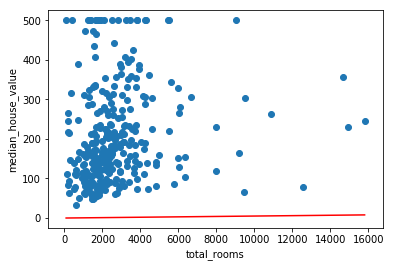

In [150]:
# min total room values
x_0 = sample['total_rooms'].min()
x_1 = sample['total_rooms'].max()

# retrieve final weight and bias retrieved while training
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# get the predicted median_house_values for the min and max total total room values
y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias 

# plot regression line
plt.plot([x_0, x_1],[y_0, y_1], c='r')

# label graph axes
plt.ylabel('median_house_value')
plt.xlabel('total_rooms')

# plot scatter plot from data sample
plt.scatter(sample['total_rooms'], sample['median_house_value'])

plt.show()

In [151]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """
  Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

## Attempt to achieve RMSE <= 180

Training model...
RMSE (on training data):
  period 00 : 235.11
  period 01 : 232.70
  period 02 : 230.31
  period 03 : 227.96
  period 04 : 225.63
  period 05 : 223.32
  period 06 : 221.05
  period 07 : 218.81
  period 08 : 216.60
  period 09 : 214.42
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,26.4,207.3
std,21.8,116.0
min,0.0,15.0
25%,14.6,119.4
50%,21.3,180.4
75%,31.5,265.0
max,379.4,500.0


Final RMSE (on training data): 214.42


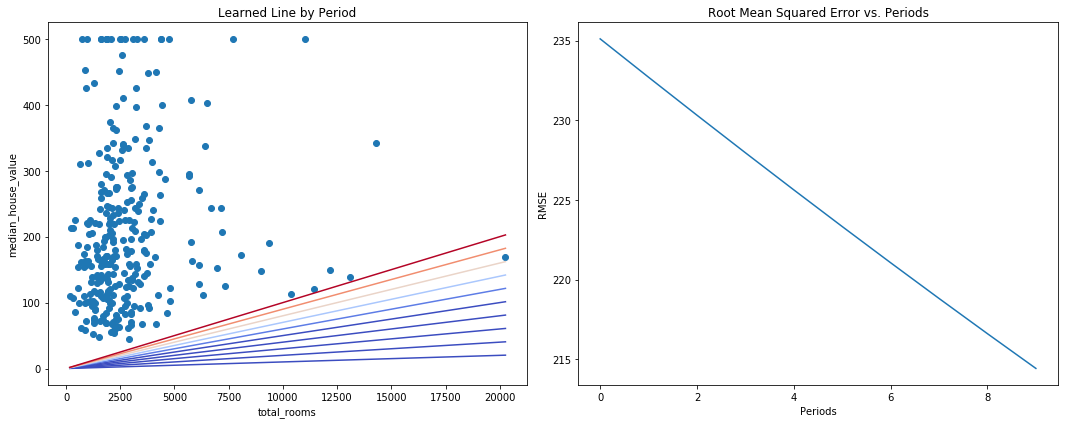

In [154]:
train_model(learning_rate=.00001, steps=200, batch_size=1)

Training model...
RMSE (on training data):
  period 00 : 231.50
  period 01 : 225.63
  period 02 : 219.93
  period 03 : 214.42
  period 04 : 209.12
  period 05 : 204.04
  period 06 : 199.39
  period 07 : 194.79
  period 08 : 190.64
  period 09 : 186.60
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,65.6,207.3
std,54.1,116.0
min,0.0,15.0
25%,36.3,119.4
50%,52.7,180.4
75%,78.2,265.0
max,940.8,500.0


Final RMSE (on training data): 186.60


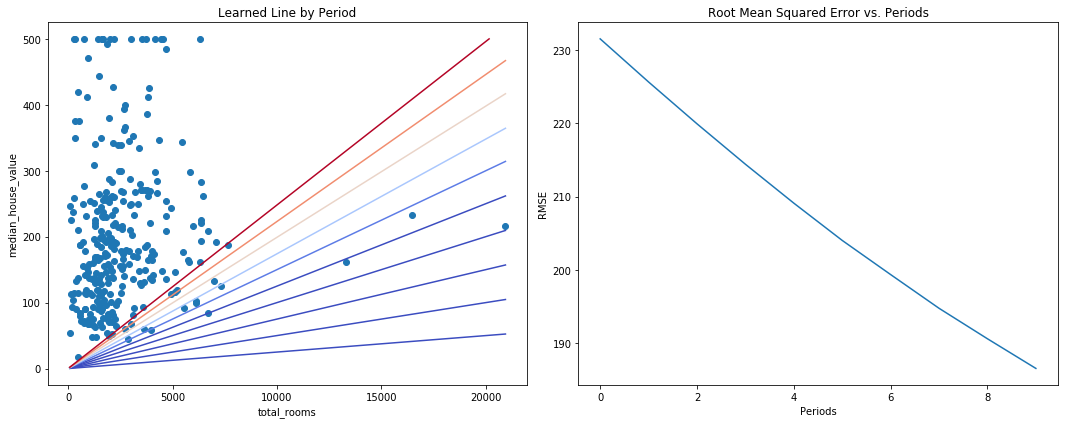

In [156]:
train_model(learning_rate=.00001, steps=500, batch_size=10)

Training model...
RMSE (on training data):
  period 00 : 186.29
  period 01 : 166.74
  period 02 : 166.53
  period 03 : 166.53
  period 04 : 167.02
  period 05 : 167.38
  period 06 : 170.16
  period 07 : 168.29
  period 08 : 170.92
  period 09 : 167.38
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,145.4,207.3
std,119.9,116.0
min,0.1,15.0
25%,80.4,119.4
50%,117.0,180.4
75%,173.3,265.0
max,2086.6,500.0


Final RMSE (on training data): 167.38


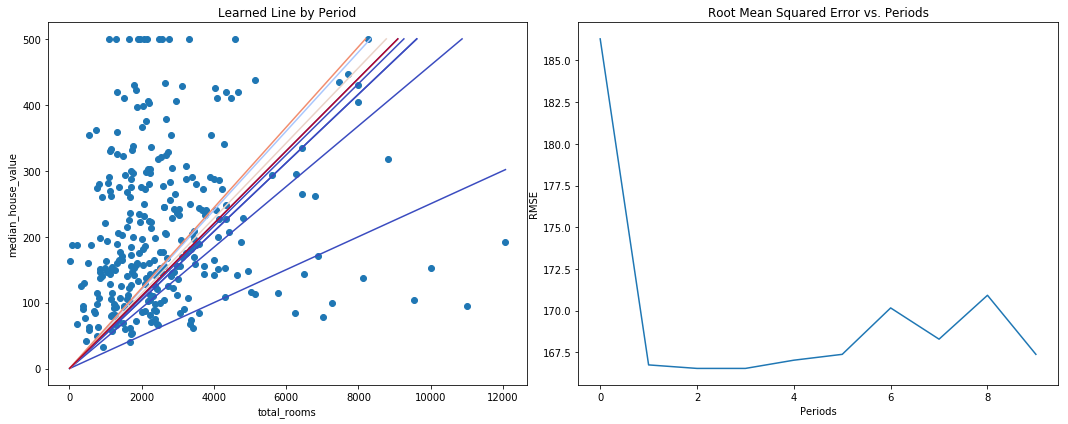

In [157]:
train_model(learning_rate=.0001, steps=500, batch_size=32)

## Try different feature

In [160]:
import seaborn as sns

In [158]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


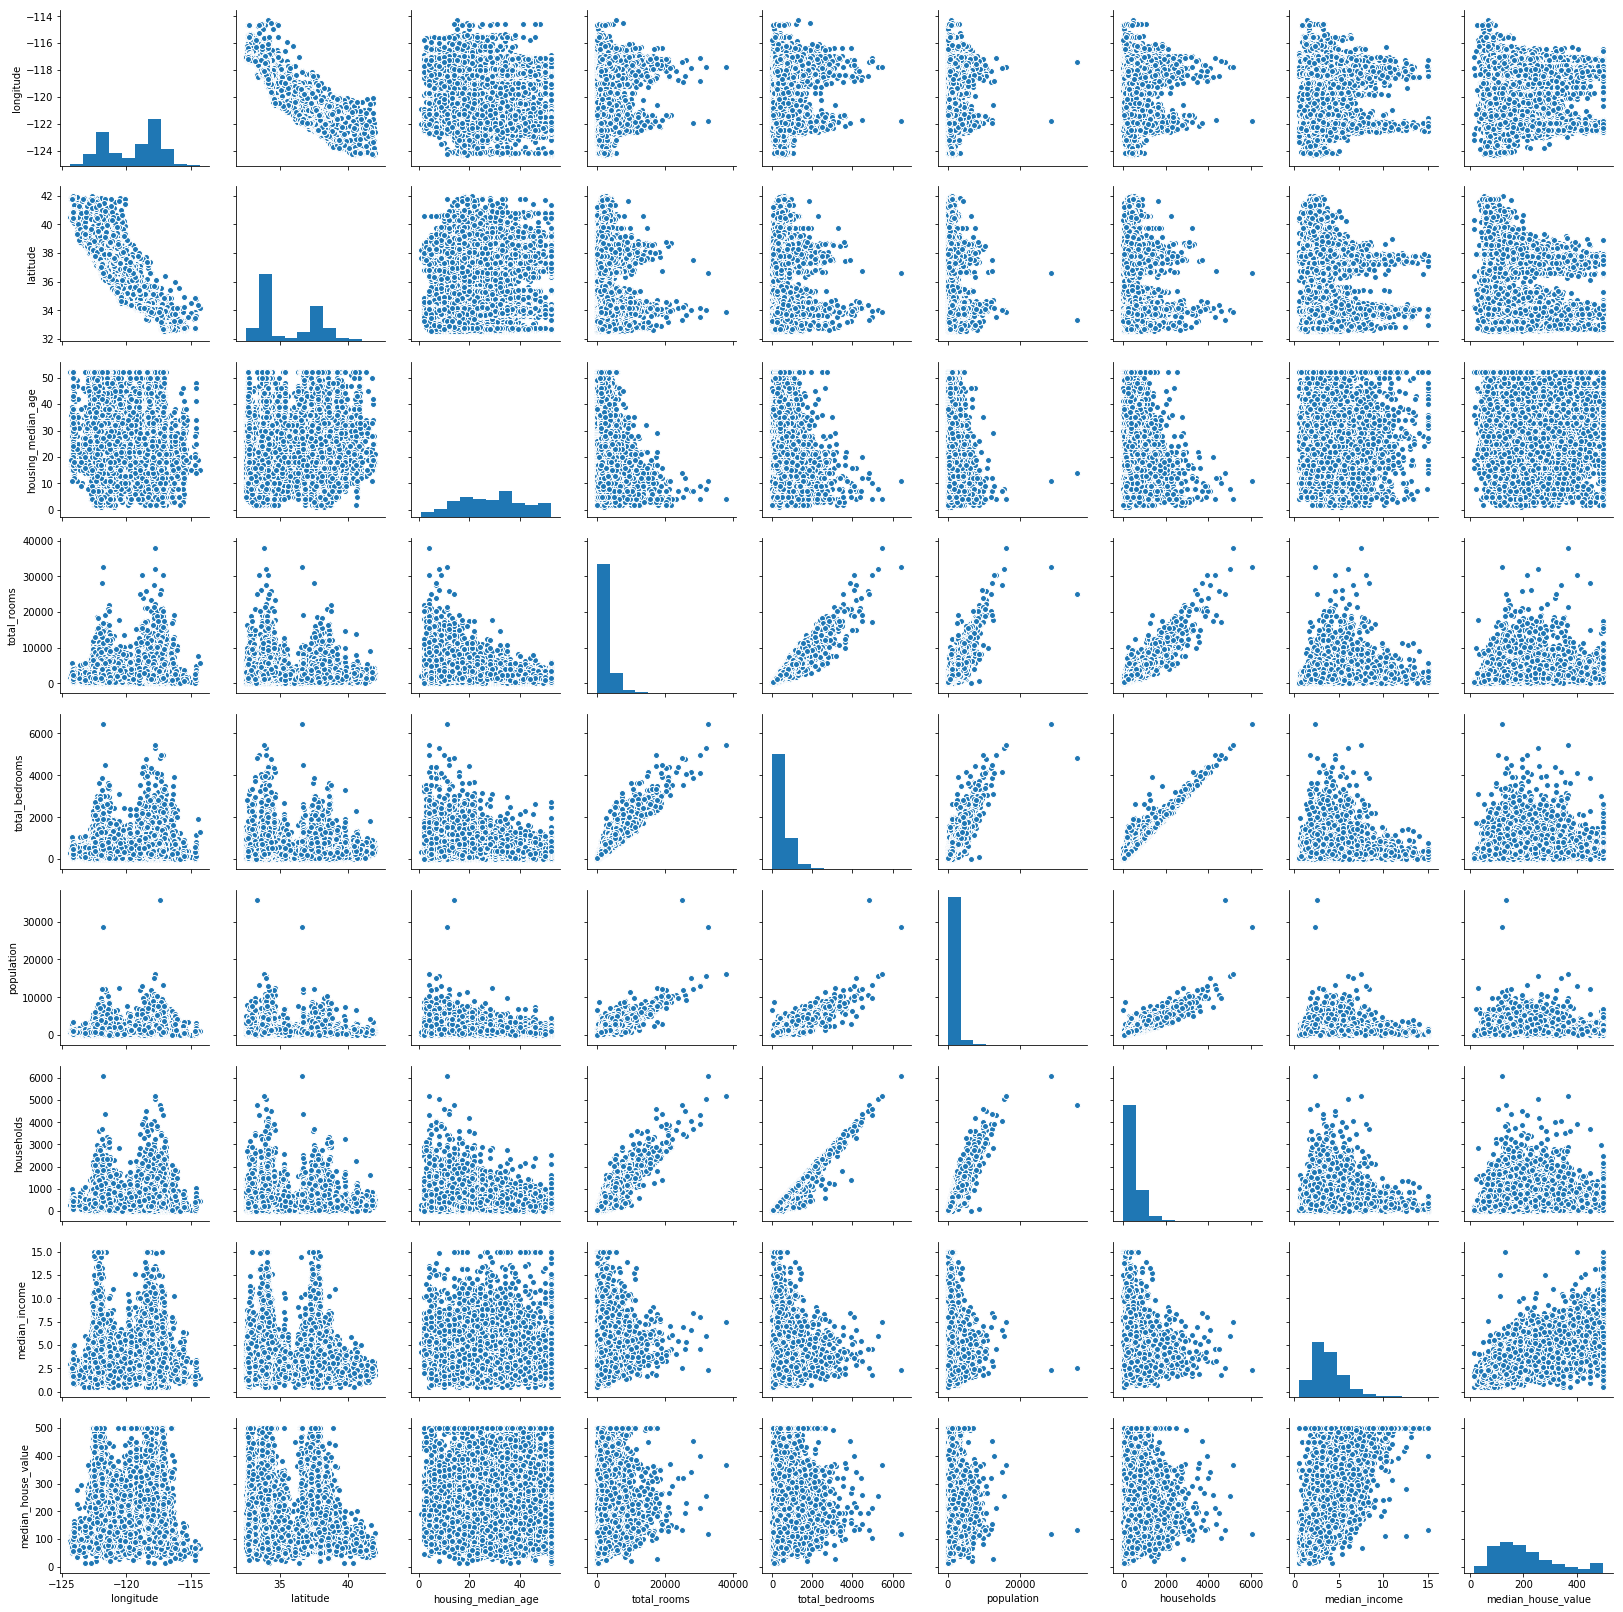

In [161]:
sns.pairplot(california_housing_dataframe)

Training model...
RMSE (on training data):
  period 00 : 226.59
  period 01 : 216.24
  period 02 : 206.58
  period 03 : 197.71
  period 04 : 189.75
  period 05 : 183.06
  period 06 : 177.63
  period 07 : 173.25
  period 08 : 170.62
  period 09 : 168.88
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,114.8,207.3
std,88.0,116.0
min,0.2,15.0
25%,64.6,119.4
50%,93.6,180.4
75%,138.6,265.0
max,1392.6,500.0


Final RMSE (on training data): 168.88


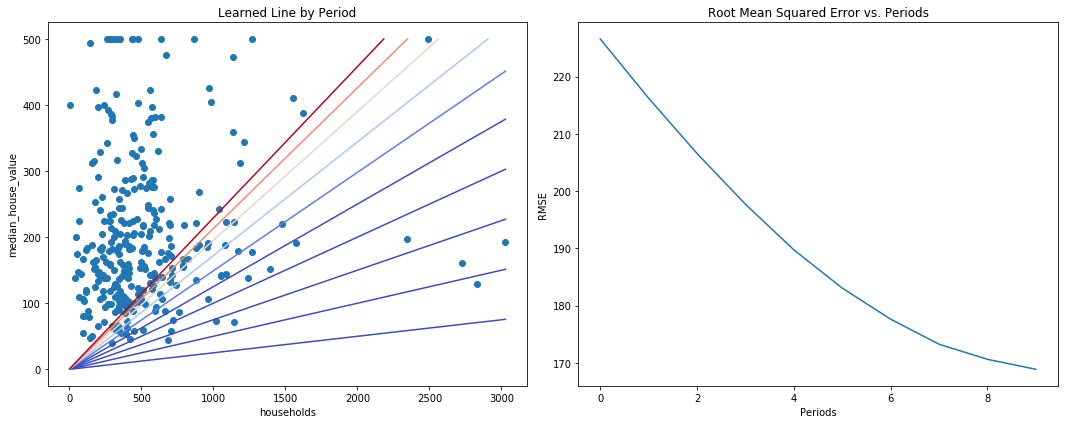

In [178]:
train_model(learning_rate=.0001, steps=500, batch_size=32, input_feature='households')